In [1]:
print("Hello World")

Hello World


##### step D.1 --> Imports and Load Saved Data 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score


In [3]:
pca_features = np.load("../app/pca_features.npy")
tsne_3d = np.load("../app/tsne_3d.npy")

print(pca_features.shape, tsne_3d.shape)


(1000, 50) (1000, 3)


##### Step D.2 --> K - MEANS (Forced Structure)

Why K=10?

CIFAR-10 has 10 semantic categories

We are not using labels

We are testing whether embeddings naturally separate

In [4]:
kmeans = KMeans(n_clusters = 10, random_state = 42)
kmeans_labels = kmeans.fit_predict(pca_features)

##### Step D.3 --> Evaluate K - Means

In [5]:
silhouette = silhouette_score(pca_features, kmeans_labels)
silhouette 

0.07138659060001373

0.4–0.6 → decent unsupervised separation

>0.6 → very strong structure

<0.2 → forced clustering

##### Step D.4 --> Visualize the K - Means on t-SNE Space

In [6]:
df_kmeans = pd.DataFrame(tsne_3d, columns = ["x", "y", "z"])
df_kmeans["cluster"] = kmeans_labels
df_kmeans["image_3d"] = range(len(df_kmeans))

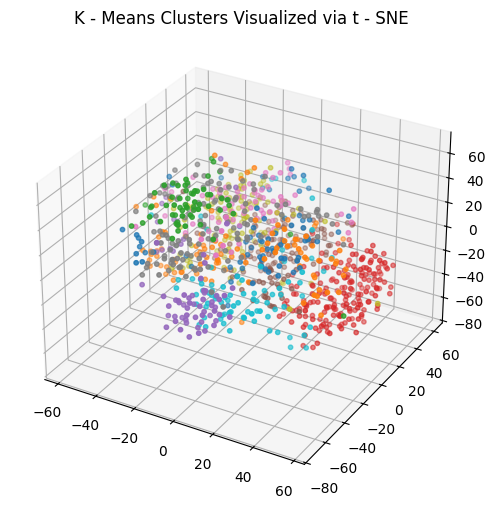

In [7]:
from mpl_toolkits.mplot3d import Axes3D

fig =  plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection = "3d")

ax.scatter(
    df_kmeans["x"],
    df_kmeans["y"],
    df_kmeans["z"],
    c = df_kmeans["cluster"],
    cmap = "tab10",
    s = 10 
)
ax.set_title("K - Means Clusters Visualized via t - SNE")
plt.show()


##### Step D.5 --> DBSCAN (Let the Data Decide)

In [8]:
dbscan = DBSCAN(eps = 2.5, min_samples = 10)
dbscan_labels = dbscan.fit_predict(pca_features)

##### Step D.6 --> Analyzing the DBSCAN Output 

In [10]:
unique_labels = set(dbscan_labels)
unique_labels 


# -1 --> Outliters and the other integers indicate the discovered clusters

{np.int64(-1)}

In [ ]:
num_outliers = np.sum(dbscan_labels == -1) # vectorize comparison 
num_outliers 

np.int64(1000)

In NumPy : True is treated as 1, False is treated as 0

So : np.sum([False, False, False, True, False, True, False])
becomes : 0 + 0 + 0 + 1 + 0 + 1 + 0 = 2
So it counts how many Trues there are.

So --> Count how many entries in dbscan_labels are equal to -1.

Why CIFAR-10 breaks DBSCAN

CIFAR-10 images are:
32 × 32 pixels, 3 color channels
→ 3072 dimensions per image

So each image is a point in ℝ³⁰⁷².

DBSCAN depends on Euclidean distance to decide:
“Which points are close?”
But in high-dimensional spaces : All distances become almost the same.
This is called the curse of dimensionality.

So DBSCAN sees : distance(image A, image B) ≈ distance(image A, image C) ≈ distance(image A, image D)


Meaning : No tight neighborhoods, No dense regions
Everything looks isolated

→ DBSCAN labels most points as noise (-1)
The  1000 outliers are not a bug — they are a mathematical inevitability.

In [14]:
N = len(dbscan_labels)
N

1000

##### Step D.7 --> Visualize the DBSCAN Results 

In [15]:
df_dbscan = pd.DataFrame(tsne_3d, columns = ["x", "y", "z"])
df_dbscan["cluster"] = dbscan_labels


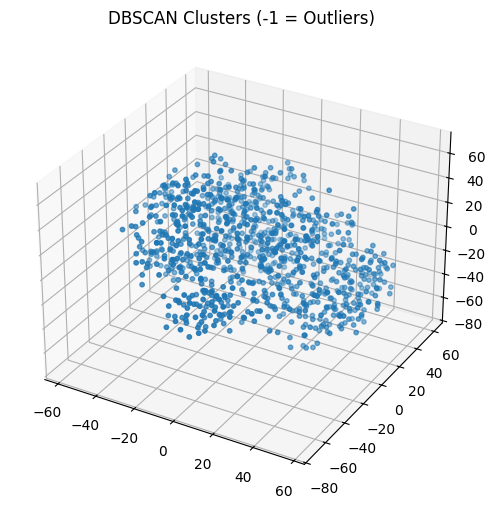

In [18]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection="3d")

scatter = ax.scatter(
    df_dbscan["x"],
    df_dbscan["y"],
    df_dbscan["z"],
    c=df_dbscan["cluster"],
    cmap="tab20",
    s=10
)

ax.set_title("DBSCAN Clusters (-1 = Outliers)")
plt.show()


| Aspect           | K-Means   | DBSCAN         |
| ---------------- | --------- | -------------- |
| Needs K          | Yes       | No             |
| Shape assumption | Spherical | Arbitrary      |
| Handles outliers | No         | Yes           |
| Density aware    | No        | Yes            |
| Stable clusters  | Yes       | Depends on eps |


##### Step D.8 --> Save The final Visualization Data (For Streamlit)

In [19]:
final_df = pd.DataFrame(tsne_3d, columns=["x", "y", "z"])
final_df["kmeans_cluster"] = kmeans_labels
final_df["dbscan_cluster"] = dbscan_labels
final_df["image_id"] = range(len(final_df))

final_df.to_csv("../app/viz_data.csv", index=False)
